# Project 3: Getting Started 

This notebook is intended to help you get off to a flying start with the cars dataset. You don't have to use this notebook and you can discard any parts you do not like, they are purely intended as a help to get started. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats 
sns.set_theme()

# optimization
from scipy import optimize
import estimation as est
import clogit
import functions as fn

import statsmodels.formula.api as smf

# Read in data

The dataset, `cars.csv`, contains cleaned and processed data. If you want to make changes, the notebook, `materialize.ipynb`, creates the data from the raw source datsets. 

In [2]:
cars = pd.read_csv('cars.csv')
lbl_vars = pd.read_csv('labels_variables.csv')
lbl_vals = pd.read_csv('labels_values.csv')

# convert from dataframe to dict
lbl_vals = {c: lbl_vals[c].dropna().to_dict() for c in lbl_vals.columns}

In [3]:
lbl_vars.set_index('variable', inplace=True)

## Overview of the dataset

In [4]:
lbl_vars.join(cars.mean(numeric_only=True).apply(lambda x: f'{x: .2f}').to_frame('Mean'))

,label,Mean
variable,,
ye,year (=first dimension of panel),84.50
ma,market (=second dimension of panel),3.00
co,model code (=third dimension of panel),207.50
zcode,alternative model code (predecessors and succe...,177.76
brd,brand code,16.79
type,name of brand and model,NaN
brand,name of brand,NaN
model,name of model,NaN
org,"origin code (demand side, country with which c...",2.72


# Set up for analysis

In [5]:
# a. pic the prince variable 
price_var = 'princ'

# b. new variable: log of price
cars['logp'] = np.log(cars[price_var])

# c. new variable: price elasticity heterogeneous for home-region 
cars['logp_x_home'] = cars[price_var] * cars['home']

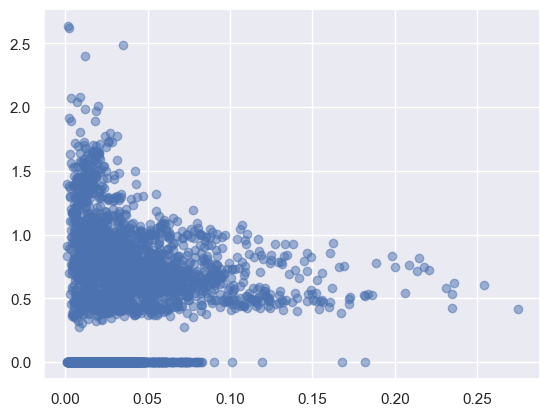

In [6]:
plt.plot(cars['s'], cars['logp_x_home'], 'o', alpha=0.5)

### Dummy variables

For working with matrices, we want to have a column for each dummy variable. 

In [7]:
categorical_var = 'brand' # name of categorical variable
dummies = pd.get_dummies(cars[categorical_var]) # creates a matrix of dummies for each value of dummyvar
x_vars_dummies = list(dummies.columns[1:].values) # omit a reference category, here it is the first (hence columns[1:])

# add dummies to the dataframe 
assert dummies.columns[0] not in cars.columns, f'It looks like you have already added this dummy to the dataframe. Avoid duplicates! '
cars = pd.concat([cars, dummies], axis=1)


### `x_vars`: List of regressors to be used 

In [8]:
# 
# x_vars = ['logp', 'home', 'cy', 'hp', 'we', 'li'] + x_vars_dummies # <--- !!! choose your preferred variables here 
x_vars = ['logp', 'home',
            # 'sp', 
            # 'he', 
          'hp', 'cy','we','li'] + x_vars_dummies # <--- !!! choose your preferred variables here 
print(f'K = {len(x_vars)} variables selected.')

# add price elasticity heterogeneous for home-region 
x_vars_new = x_vars + ['logp_x_home']
x_vars_new_new = x_vars_new[2:]

K = 38 variables selected.


In [9]:
# a. set up the data for the estimation
K = len(x_vars)
N = cars.ma.nunique() * cars.ye.nunique()
J = 40 
x = cars[x_vars].values.reshape((N,J,K)).astype(np.float64)
# b. define new x with the interaction term
x_new = cars[x_vars_new].values.reshape((N,J,K+1)).astype(np.float64)
x_new_new = cars[x_vars_new_new].values.reshape((N,J,K-1)).astype(np.float64)
# c. define y
y = cars['s'].values.reshape((N,J))

# Conditional Logit

## Estimate of x

In [11]:
# Starting values 
theta0 = clogit.starting_values(y, x)

In [12]:
# Find results
res = est.estimate(clogit.q, theta0, y, x, cov_type = 'Sandwich')

Optimization terminated successfully.
         Current function value: 3.473342
         Iterations: 300
         Function evaluations: 12012
         Gradient evaluations: 308


In [13]:
# Estimate the model, standard errors, and t-values
est.print_table(x_vars,res)

Optimizer succeded after 300 iter. (12012 func. evals.). Final criterion:    3.473.
Results


,theta,se,t,p-value
logp,-0.1615,0.1024,-1.5773,0.1176
home,1.3617,0.0326,41.7344,0.0000
hp,-0.0143,0.0020,-7.0115,0.0000
cy,-0.0001,0.0001,-1.5775,0.1176
we,0.0005,0.0002,2.8612,0.0050
li,-0.0313,0.0161,-1.9473,0.0540
MCC,-1.3593,0.0992,-13.7005,0.0000
VW,0.1816,0.0300,6.0578,0.0000
alfa romeo,-0.7119,0.0601,-11.8494,0.0000
audi,-0.1062,0.0397,-2.6769,0.0086


# Estimation of Parameters of Intrest

In [17]:
# Without interaction term
fn.result(x,res['theta'],res['cov'],print_out = True,se=True,inter=False,N=N,x_vars=x_vars)

,Estimate,se,CI low,CI high,p-value
PEA,0.0372,0.0000,0.0372,0.0372,0.0000
MWP,8.4332,2.3323,3.8620,13.0044,0.0004
E_H,-0.1535,0.0008,-0.1550,-0.1520,0.0000
E_F,-0.1579,0.0008,-0.1595,-0.1563,0.0000
